In [91]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
from scipy.spatial import cKDTree

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

FIG_DIR = 'Figures'

In [ ]:
from matplotlib.colors import ListedColormap
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = ListedColormap(turbo_colormap_data, name="turbo")



In [86]:
zarr_store  = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
zarr_store_pred = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA_test.zarr'
mask = xr.open_dataset('mask_2d.nc').mask

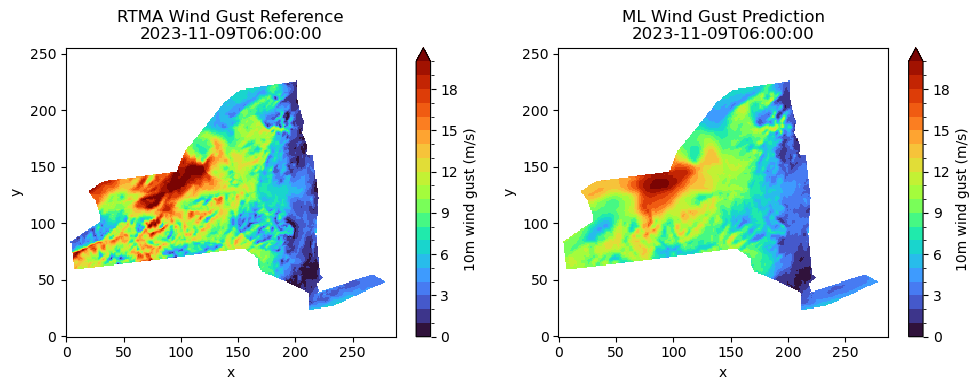

In [92]:
cmap = turbo_cmap
levels = np.arange(0, 20.1, 1)
time_instance = '2023-11-09T06:00:00'
ref = xr.open_zarr(zarr_store).i10fg.sel(time=time_instance).where(mask)
pred = xr.open_zarr(zarr_store_pred).i10fg.sel(time=time_instance).where(mask)
# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot test data
test_plot = ref.plot(
    ax=axes[0],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': '10m wind gust (m/s)'}
)
axes[0].set_title('RTMA Wind Gust Reference\n' + time_instance, fontsize=12)
# Plot prediction
pred_plot = pred.plot(
    ax=axes[1],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': '10m wind gust (m/s)'}
)
axes[1].set_title('ML Wind Gust Prediction\n' + time_instance, fontsize=12)

plt.tight_layout()

plt.savefig(FIG_DIR+'/RTMA_Wind_Gust_Comparison.png', dpi=300)

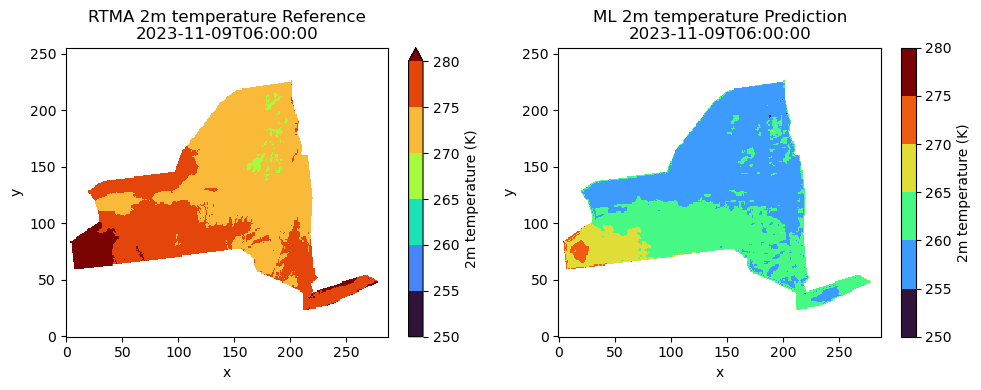

In [93]:
cmap = turbo_cmap
levels = np.arange(250, 280.1, 5)
time_instance = '2023-11-09T06:00:00'
ref = xr.open_zarr(zarr_store).t2m.sel(time=time_instance).where(mask)
pred = xr.open_zarr(zarr_store_pred).t2m.sel(time=time_instance).where(mask)
var_title = '2m temperature'
cbar_label = '2m temperature (K)'
# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot test data
test_plot = ref.plot(
    ax=axes[0],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': cbar_label}
)
axes[0].set_title(f'RTMA {var_title} Reference\n' + time_instance, fontsize=12)
# Plot prediction
pred_plot = pred.plot(
    ax=axes[1],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': cbar_label}
)
axes[1].set_title(f'ML {var_title} Prediction\n' + time_instance, fontsize=12)

plt.tight_layout()

plt.savefig(FIG_DIR+'/RTMA_2m_temperature_Comparison.png', dpi=300)

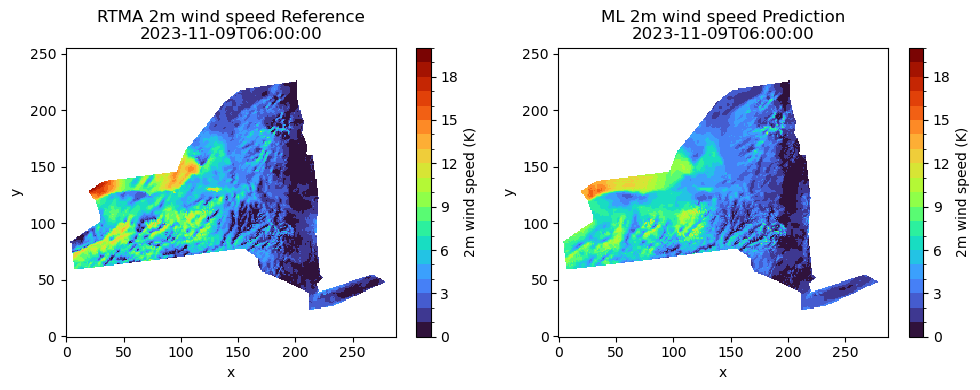

In [94]:
cmap = turbo_cmap
levels = np.arange(0, 20.1, 1)
time_instance = '2023-11-09T06:00:00'
ref = xr.open_zarr(zarr_store).si10.sel(time=time_instance).where(mask)
pred = xr.open_zarr(zarr_store_pred).si10.sel(time=time_instance).where(mask)
var_title = '2m wind speed'
cbar_label = '2m wind speed (K)'
# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot test data
test_plot = ref.plot(
    ax=axes[0],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': cbar_label}
)
axes[0].set_title(f'RTMA {var_title} Reference\n' + time_instance, fontsize=12)
# Plot prediction
pred_plot = pred.plot(
    ax=axes[1],
    cmap=cmap,
    levels=levels,
    add_colorbar=True,
    cbar_kwargs={'label': cbar_label}
)
axes[1].set_title(f'ML {var_title} Prediction\n' + time_instance, fontsize=12)

plt.tight_layout()

plt.savefig(FIG_DIR+'/RTMA_wind_speed_Comparison.png', dpi=300)